In [2]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files       = loadDataset(data_dir,'T5/historical/')
files       = np.concatenate([files, loadDataset(data_dir, 'T5/new/')])
files       = get_Sessions(files, min_nblocks, manually_remove = None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def findBursts(file, cfg):
    '''Prep session data for RNN'''
    
    session       = DataStruct(file, alignScreens = True, causal_filter = cfg['sigma'])

    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], 
                                                     blocks = cfg['blocks'], returnFlattened = True)
    
    train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y          = np.concatenate(train_y)
    test_y           = np.concatenate(test_y)
    
    neural = np.concatenate([train_x, test_x])

    return np.max(neural)



def prepareSessionForRNN(file, cfg):
    '''Prep session data for RNN'''
    
    session       = DataStruct(file, alignScreens = True, causal_filter = cfg['sigma'])

    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], 
                                                     blocks = cfg['blocks'], returnFlattened = True)
    
    train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    
    # standardize velocities to be in [-1, 1]
    ymax     = max(np.max(train_y), np.max(test_y))
    train_y /= ymax
    test_y  /= ymax

    # normalize input features
    thresh   = np.percentile(train_x, 99) * 2 
    test_x[np.abs(test_x) > thresh] = thresh * np.sign(test_x[np.abs(test_x) > thresh])

    input_sd = np.std(train_x, axis = 0)
    train_x[:, input_sd != 0] /= input_sd[None, input_sd != 0]
    test_x[:, input_sd != 0]  /= input_sd[None, input_sd != 0]

    # generate sequences to support minibatch training 
    x_train  = convert_to_seqs(train_x, seqlen = cfg['seqlen'])
    y_train  = convert_to_seqs(train_y, seqlen = cfg['seqlen'])

    x_val    = [test_x]
    y_val    = [test_y] 
    
    return x_train, y_train, x_val, y_val
    

In [11]:
# Get initial day performance and decoder:
cfg = dict()
cfg['train_size'] = 0.67
cfg['task']       = None
cfg['blocks']     = None
cfg['sigma']      = 2

noiseMax = np.zeros((len(files),))

for i, file in enumerate(files):
    noiseMax[i] = findBursts(file, cfg)
    
    if (i + 1) % 10 == 0:
        print(i + 1, '/', len(files))

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


10 / 77
20 / 77
30 / 77
40 / 77
50 / 77
60 / 77
70 / 77


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


original $R^2$:  0.41020877265653427
new $R^2$:  0.40836925553557024


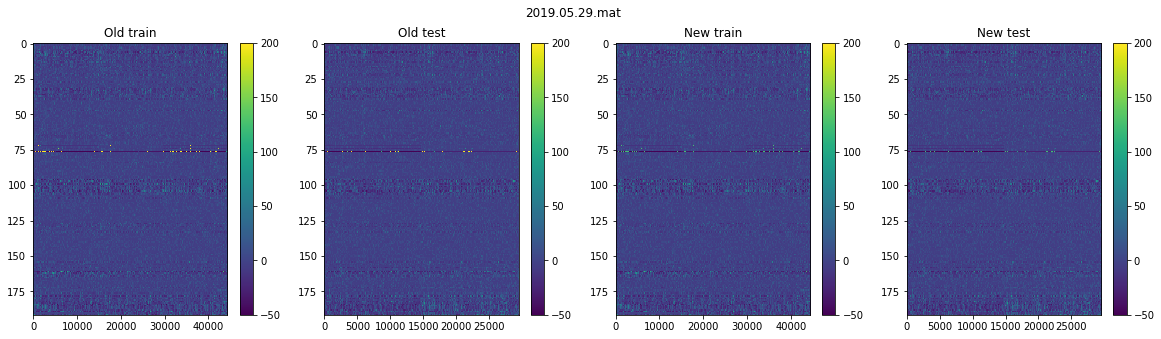

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.36022404478169534
new $R^2$:  0.3548259754487594


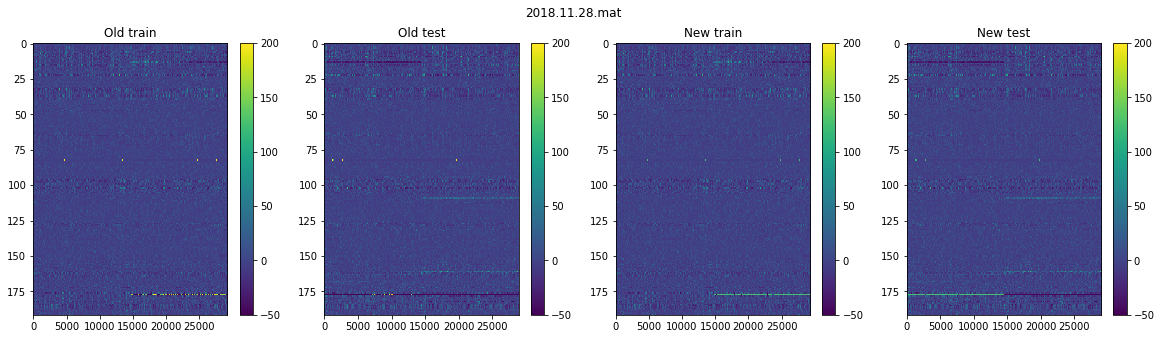

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.3828567631662048
new $R^2$:  0.38269945029527336


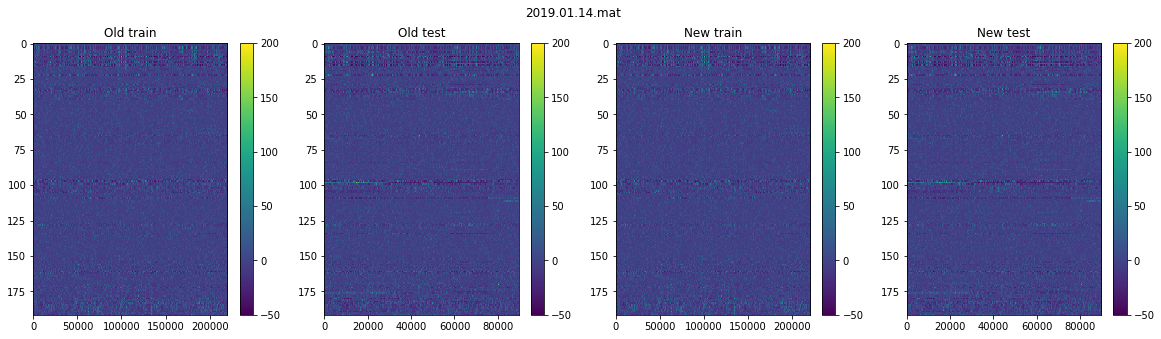

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.4979466929746084
new $R^2$:  0.4978371661582178


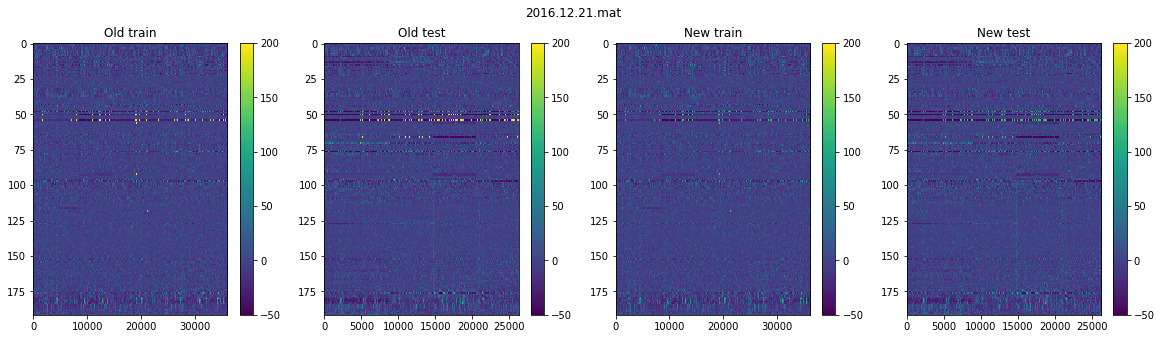

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.1498778591340679
new $R^2$:  0.1482265977345177


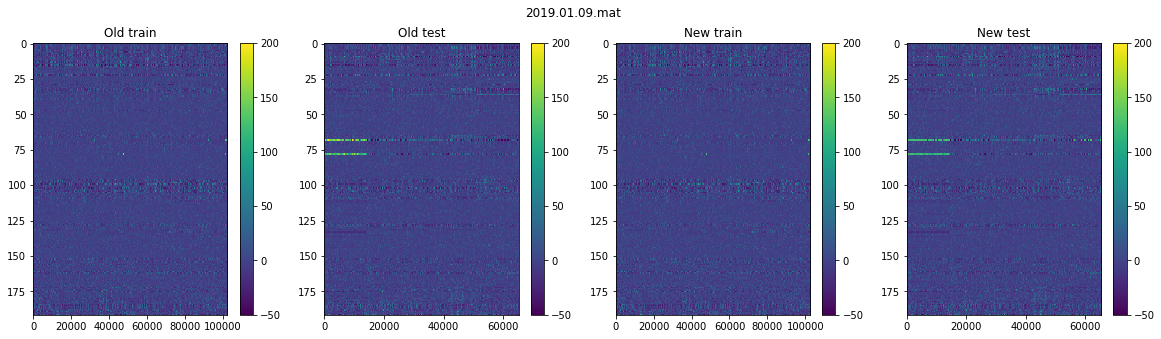

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.19429021698552046
new $R^2$:  0.19949049790657103


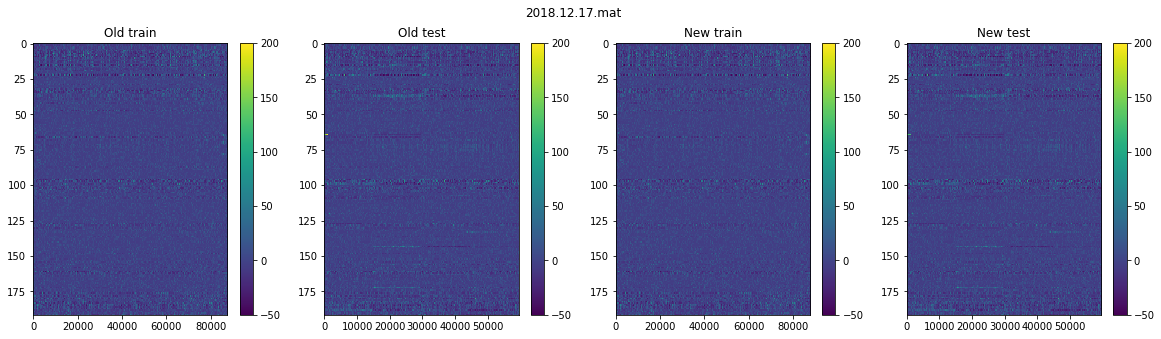

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.08957628801579302
new $R^2$:  0.12442167238121431


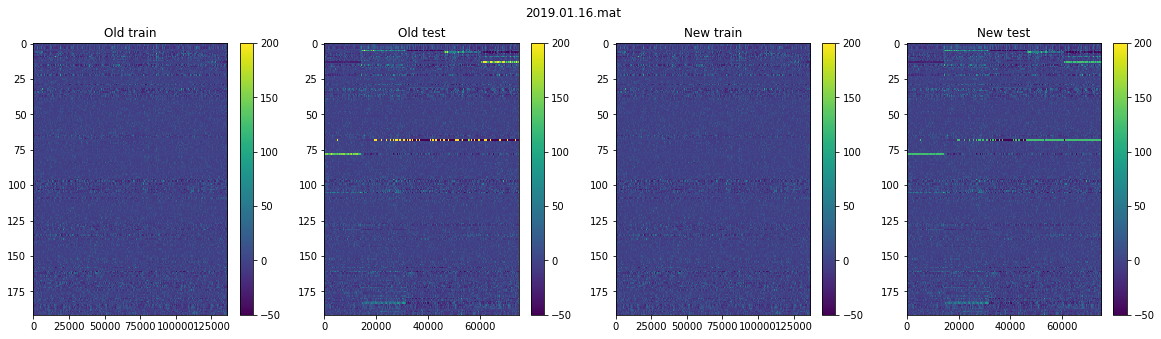

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.47482192752023056
new $R^2$:  0.47445423945606263


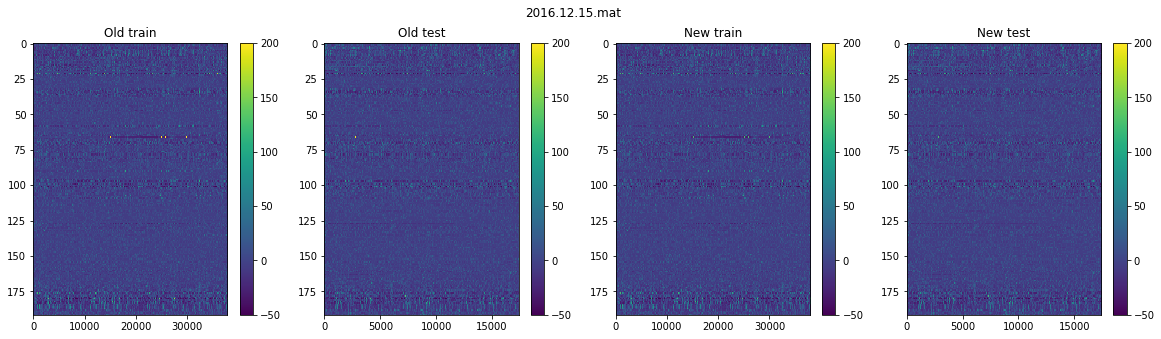

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.12687368149857872
new $R^2$:  0.1279760897462636


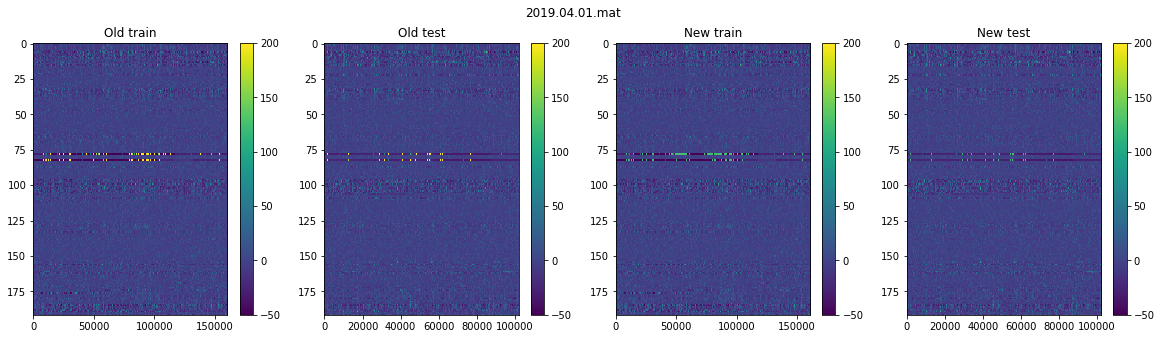

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
original $R^2$:  0.3053279230856086
new $R^2$:  0.30464570591918755


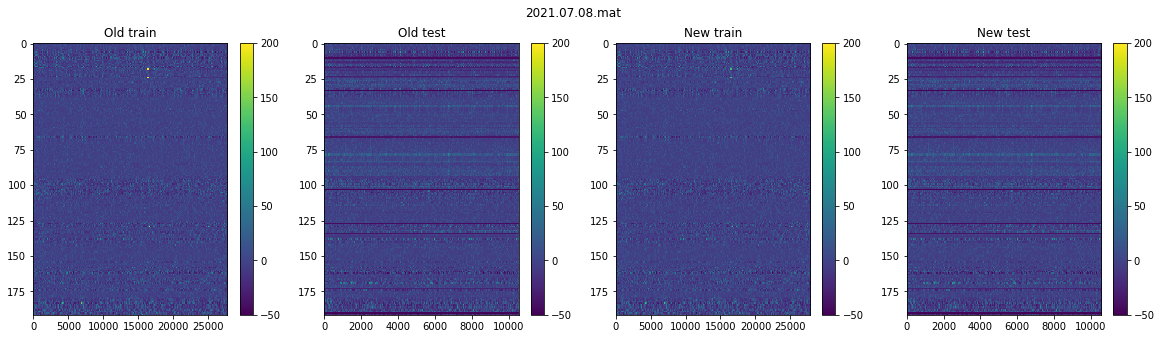

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [82]:
figSize(5, 20)

top_k = 10
clim  = [-50, 200]

noisy_idx = np.argsort(noiseMax)[::-1]


for idx in noisy_idx[:top_k]:
    
    session       = DataStruct(files[idx], alignScreens = True, causal_filter = cfg['sigma'])
    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], blocks = cfg['blocks'], returnFlattened = True)
    train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y          = np.concatenate(train_y)
    test_y           = np.concatenate(test_y)
    
    print('original $R^2$: ', LinearRegression(normalize = True).fit(train_x, train_y).score(test_x, test_y))
    plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(train_x.T, aspect = 'auto')
    plt.clim(clim)
    plt.colorbar()
    plt.title('Old train')
    
    plt.subplot(1, 4, 2)
    plt.imshow(test_x.T, aspect = 'auto')
    plt.clim(clim)
    plt.colorbar()
    plt.title('Old test')
    
    # normalize input features
    thresh   = 125
    medians    = np.median(train_x, axis = 0)
    medians_a  = medians + np.zeros(train_x.shape)
    medians_b  = medians + np.zeros(test_x.shape)

    #train_x[np.abs(train_x) > thresh] = medians_a[np.abs(train_x) > thresh]
    #test_x[np.abs(test_x) > thresh]   = medians_b[np.abs(test_x) > thresh]
    
    train_x[np.abs(train_x) > thresh] = thresh * np.sign(np.abs(train_x) > thresh)
    test_x[np.abs(test_x) > thresh]   = thresh * np.sign(np.abs(train_x) > thresh)

    print('new $R^2$: ', LinearRegression(normalize = True).fit(train_x, train_y).score(test_x, test_y))
    plt.subplot(1, 4, 3)
    plt.imshow(train_x.T, aspect = 'auto')
    plt.clim(clim)
    plt.colorbar()
    plt.title('New train')
    
    plt.subplot(1, 4, 4)
    plt.imshow(test_x.T, aspect = 'auto')
    plt.clim(clim)
    plt.colorbar()
    plt.title('New test')
    plt.suptitle(files[idx].split('t5.')[1])
    
    plt.show()
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
   # break


In [79]:
session       = DataStruct(files[idx], alignScreens = True, causal_filter = 0)
#plt.imshow(session.TX_continuous, )
#plt.show()

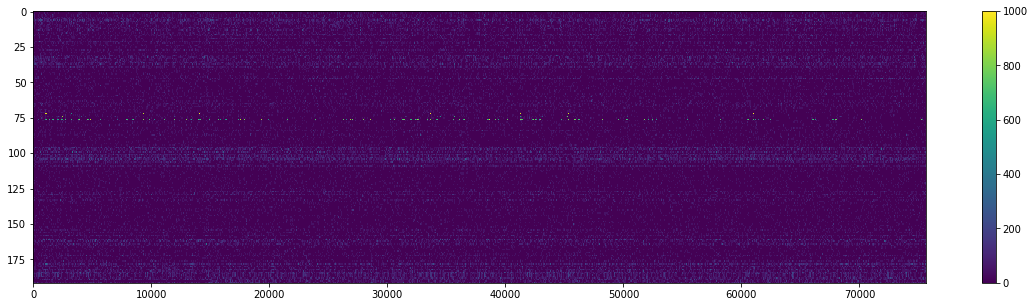

In [80]:
#session.TX_continuous[session.TX_continuous > 400] = 400

plt.imshow(session.TX_continuous.T, aspect ='auto')
plt.colorbar()
plt.show()

In [ ]:
session       = DataStruct(files[idx], alignScreens = True, causal_filter = cfg['sigma'])
train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], blocks = cfg['blocks'], returnFlattened = True)
train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
train_y          = np.concatenate(train_y)
test_y           = np.concatenate(test_y)

print('original $R^2$: ', LinearRegression().fit(train_x, train_y).score(test_x, test_y))
plt.figure()
plt.subplot(1, 4, 1)
plt.imshow(train_x.T, aspect = 'auto')
plt.clim(clim)
plt.colorbar()
plt.title(files[idx].split('t5.')[1])

plt.subplot(1, 4, 2)
plt.imshow(test_x.T, aspect = 'auto')
plt.clim(clim)
plt.colorbar()
plt.title(files[idx].split('t5.')[1])

# normalize input features
thresh   = 125
medians    = np.median(train_x, axis = 0)
medians_a  = medians + np.zeros(train_x.shape)
medians_b  = medians + np.zeros(test_x.shape)

train_x[np.abs(train_x) > thresh] = medians_a[np.abs(train_x) > thresh]
test_x[np.abs(test_x) > thresh]   = medians_b[np.abs(test_x) > thresh]

print('new $R^2$: ', LinearRegression(normalize = False).fit(train_x, train_y).score(test_x, test_y))
plt.subplot(1, 4, 3)
plt.imshow(train_x.T, aspect = 'auto')
plt.clim(clim)
plt.colorbar()
plt.title(files[idx].split('t5.')[1])

plt.subplot(1, 4, 4)
plt.imshow(test_x.T, aspect = 'auto')
plt.clim(clim)
plt.colorbar()
plt.title(files[idx].split('t5.')[1])

plt.show()
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
#break
